In [1]:
#!pip install konlpy

In [2]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/

In [3]:
!cp /content/drive/MyDrive/Downloads/ratings_test.txt /content/

In [6]:
!cp /content/drive/MyDrive/Downloads/ratings_train.txt /content

In [176]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt

import re

from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

from collections import Counter

train_data = pd.read_table('/content/ratings_train.txt')
test_data = pd.read_table('/content/ratings_test.txt')


In [195]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return (X_train, np.array(list(train_data['label']))), (X_test, np.array(list(test_data['label']))), word_to_index


In [196]:
(X_train, y_train), (X_test, y_test), word_to_index = load_data(train_data, test_data) 

In [215]:
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2

In [216]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [218]:
index_to_word[1]

'<BOS>'

In [219]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [220]:
import itertools
maxlen = max(len(x) for x in itertools.chain(X_train,X_test))

In [221]:
padded_X_train = pad_sequences(X_train,padding='pre',value=word_to_index['<PAD>'],maxlen=maxlen)
padded_X_test = pad_sequences(X_test,padding='pre',value=word_to_index['<PAD>'],maxlen=maxlen)

In [222]:
x_val = padded_X_train[:10000]
y_val = y_train[:10000]
partial_X_train = padded_X_train[10000:]  
partial_y_train = y_train[10000:]

In [223]:
len(y_test)

49157

In [224]:
vocab_size = 10000
word_vector_dim = 116


In [225]:
import tensorflow as tf
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.embed1 = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
    self.lstm1 = keras.layers.LSTM(8)
    self.dense1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x = self.embed1(inputs)
    x = self.lstm1(x)
    x = self.dense1(x)
    return self.dense2(x)


In [226]:
with tf.device('/GPU:0'):
  model = MyModel()

In [227]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [228]:
epochs=20

In [229]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 14ms/step - loss: 0.4438 - accuracy: 0.8080 - val_loss: 0.3449 - val_accuracy: 0.8511
Epoch 2/20
266/266 [==============================] - 3s 13ms/step - loss: 0.3257 - accuracy: 0.8622 - val_loss: 0.3330 - val_accuracy: 0.8551
Epoch 3/20
266/266 [==============================] - 3s 13ms/step - loss: 0.3000 - accuracy: 0.8742 - val_loss: 0.3282 - val_accuracy: 0.8588
Epoch 4/20
266/266 [==============================] - 3s 13ms/step - loss: 0.2815 - accuracy: 0.8819 - val_loss: 0.3341 - val_accuracy: 0.8567
Epoch 5/20
266/266 [==============================] - 3s 13ms/step - loss: 0.2617 - accuracy: 0.8911 - val_loss: 0.3351 - val_accuracy: 0.8548
Epoch 6/20
266/266 [==============================] - 3s 13ms/step - loss: 0.2415 - accuracy: 0.9012 - val_loss: 0.3387 - val_accuracy: 0.8600
Epoch 7/20
266/266 [==============================] - 3s 13ms/step - loss: 0.2226 - accuracy: 0.9099 - val_loss: 0.3546 - val_accuracy: 0.8576

In [230]:
import matplotlib.pyplot as plt

In [231]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

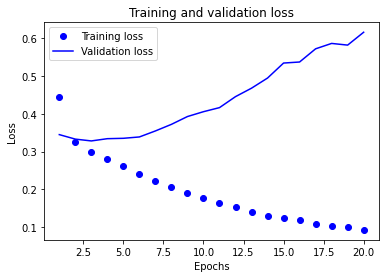

In [232]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

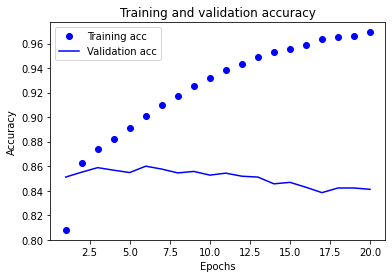

In [233]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [234]:
results = model.evaluate(padded_X_test, y_test, batch_size=128)

385/385 [==============================] - 2s 4ms/step - loss: 0.5971 - accuracy: 0.8403


In [235]:
print("test loss, test acc:", results)

test loss, test acc: [0.5971381068229675, 0.8403075933456421]


In [236]:
!cp /content/drive/MyDrive/colabdata/aiffel/ex_eight/data/ko.tsv /content

In [237]:
#!pip install gensim

In [238]:
import gensim

In [239]:
#word_vectors = gensim.models.KeyedVectors.load_word2vec_format('/content/ko.tsv')

gensim_model = gensim.models.Word2Vec.load('/content/ko.bin')

In [240]:
gensim_model.corpus_count

2203153

In [241]:
gensim_model.vector_size

200

In [242]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in gensim_model:
        embedding_matrix[i] = gensim_model[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [244]:
max_len = gensim_model.vector_size

In [245]:
padded_X_train = pad_sequences(X_train,padding='pre',value=word_to_index['<PAD>'],maxlen=maxlen)
padded_X_test = pad_sequences(X_test,padding='pre',value=word_to_index['<PAD>'],maxlen=maxlen)

In [301]:
from tensorflow.keras.initializers import Constant

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.embed1 = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True)
    self.lstm1 = keras.layers.LSTM(8)
    self.dense1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x = self.embed1(inputs)
    x = self.lstm1(x)
    x = self.dense1(x)
    return self.dense2(x)


In [302]:
with tf.device('/GPU:0'):
  model = MyModel()

In [303]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [304]:
epochs=20

In [305]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 18ms/step - loss: 0.5030 - accuracy: 0.7502 - val_loss: 0.3821 - val_accuracy: 0.8344
Epoch 2/20
266/266 [==============================] - 4s 16ms/step - loss: 0.3541 - accuracy: 0.8488 - val_loss: 0.3567 - val_accuracy: 0.8470
Epoch 3/20
266/266 [==============================] - 4s 16ms/step - loss: 0.3156 - accuracy: 0.8693 - val_loss: 0.3409 - val_accuracy: 0.8559
Epoch 4/20
266/266 [==============================] - 4s 16ms/step - loss: 0.2933 - accuracy: 0.8796 - val_loss: 0.3401 - val_accuracy: 0.8543
Epoch 5/20
266/266 [==============================] - 4s 16ms/step - loss: 0.2751 - accuracy: 0.8892 - val_loss: 0.3451 - val_accuracy: 0.8547
Epoch 6/20
266/266 [==============================] - 4s 16ms/step - loss: 0.2613 - accuracy: 0.8962 - val_loss: 0.3457 - val_accuracy: 0.8564
Epoch 7/20
266/266 [==============================] - 4s 16ms/step - loss: 0.2478 - accuracy: 0.9022 - val_loss: 0.3486 - val_accuracy: 0.8529

In [306]:
results = model.evaluate(padded_X_test, y_test, batch_size=128)

385/385 [==============================] - 2s 4ms/step - loss: 0.5214 - accuracy: 0.8397


In [307]:
print("test loss, test acc:", results)

test loss, test acc: [0.5213637351989746, 0.8396565914154053]


In [308]:
from tensorflow.keras.initializers import Constant

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.embed1 = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True)
    self.conv1 = keras.layers.Conv1D(16, 7, activation='relu')
    self.mpool1 = keras.layers.MaxPooling1D(5)
    self.conv2 = keras.layers.Conv1D(16, 7, activation='relu')
    self.gpool1 = keras.layers.GlobalMaxPooling1D()
    self.lstm1 = keras.layers.LSTM(8)
    self.dense1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x = self.embed1(inputs)
    x = self.conv1(x)
    x = self.mpool1(x)
    x = self.conv2(x)
    x = self.lstm1(x)
    x = self.dense1(x)
    return self.dense2(x)


In [309]:
with tf.device('/GPU:0'):
  model = MyModel()

In [310]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [320]:
epochs=8

In [317]:

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/8
266/266 [==============================] - 6s 18ms/step - loss: 0.5744 - accuracy: 0.7080 - val_loss: 0.4496 - val_accuracy: 0.8017
Epoch 2/8
266/266 [==============================] - 4s 16ms/step - loss: 0.3927 - accuracy: 0.8333 - val_loss: 0.3757 - val_accuracy: 0.8379
Epoch 3/8
266/266 [==============================] - 4s 16ms/step - loss: 0.3314 - accuracy: 0.8623 - val_loss: 0.3545 - val_accuracy: 0.8453
Epoch 4/8
266/266 [==============================] - 4s 16ms/step - loss: 0.2968 - accuracy: 0.8797 - val_loss: 0.3496 - val_accuracy: 0.8483
Epoch 5/8
266/266 [==============================] - 4s 16ms/step - loss: 0.2710 - accuracy: 0.8936 - val_loss: 0.3583 - val_accuracy: 0.8480
Epoch 6/8
266/266 [==============================] - 4s 16ms/step - loss: 0.2495 - accuracy: 0.9041 - val_loss: 0.3613 - val_accuracy: 0.8489
Epoch 7/8
266/266 [==============================] - 4s 16ms/step - loss: 0.2291 - accuracy: 0.9144 - val_loss: 0.3754 - val_accuracy: 0.8482
Epoch 

In [318]:
results = model.evaluate(padded_X_test, y_test, batch_size=128)

385/385 [==============================] - 1s 3ms/step - loss: 0.4058 - accuracy: 0.8414


In [319]:
print("test loss, test acc:", results)

test loss, test acc: [0.4057563245296478, 0.841426432132721]


In [353]:
from tensorflow.keras.initializers import Constant

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.embed1 = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_shape=(None,))
    self.conv1 = keras.layers.Conv1D(16, 7, activation='relu')
    self.mpool1 = keras.layers.MaxPooling1D(5)
    self.conv2 = keras.layers.Conv1D(16, 7, activation='relu')
    self.gpool1 = keras.layers.GlobalMaxPooling1D()
    self.lstm1 = keras.layers.LSTM(8)
    self.dense1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x = self.embed1(inputs)
    x = self.conv1(x)
    x = self.mpool1(x)
    x = self.conv2(x)
    x = self.lstm1(x)
    x = self.dense1(x)
    return self.dense2(x)


In [354]:
with tf.device('/GPU:0'):
  model = MyModel()

In [355]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [356]:
epochs=2

In [357]:

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/2
266/266 [==============================] - 6s 16ms/step - loss: 0.4512 - accuracy: 0.7807 - val_loss: 0.3379 - val_accuracy: 0.8531
Epoch 2/2
266/266 [==============================] - 4s 14ms/step - loss: 0.2960 - accuracy: 0.8778 - val_loss: 0.3180 - val_accuracy: 0.8668


In [358]:
results = model.evaluate(padded_X_test, y_test, batch_size=128)

385/385 [==============================] - 1s 3ms/step - loss: 0.3286 - accuracy: 0.8603


In [359]:
print("test loss, test acc:", results)

test loss, test acc: [0.32855409383773804, 0.8603047132492065]


In [330]:
from tensorflow.keras.initializers import Constant

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.embed1 = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True)
    self.conv1 = keras.layers.Conv1D(16, 7, activation='relu')
    self.mpool1 = keras.layers.MaxPooling1D(5)
    self.conv2 = keras.layers.Conv1D(16, 7, activation='relu')
    self.gpool1 = keras.layers.GlobalMaxPooling1D()
    self.lstm1 = keras.layers.LSTM(8)
    self.dense1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x = self.embed1(inputs)
    x = self.conv1(x)
    x = self.mpool1(x)
    x = self.conv2(x)
    x = self.gpool1(x)
    x = self.dense1(x)
    return self.dense2(x)


In [331]:
with tf.device('/GPU:0'):
  model = MyModel()

In [332]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [333]:
epochs=7

In [334]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/7
266/266 [==============================] - 4s 14ms/step - loss: 0.5445 - accuracy: 0.7073 - val_loss: 0.4384 - val_accuracy: 0.7959
Epoch 2/7
266/266 [==============================] - 4s 14ms/step - loss: 0.3888 - accuracy: 0.8273 - val_loss: 0.3731 - val_accuracy: 0.8383
Epoch 3/7
266/266 [==============================] - 4s 14ms/step - loss: 0.3288 - accuracy: 0.8593 - val_loss: 0.3576 - val_accuracy: 0.8429
Epoch 4/7
266/266 [==============================] - 4s 14ms/step - loss: 0.2939 - accuracy: 0.8772 - val_loss: 0.3536 - val_accuracy: 0.8475
Epoch 5/7
266/266 [==============================] - 4s 14ms/step - loss: 0.2688 - accuracy: 0.8895 - val_loss: 0.3578 - val_accuracy: 0.8467
Epoch 6/7
266/266 [==============================] - 4s 14ms/step - loss: 0.2472 - accuracy: 0.9004 - val_loss: 0.3575 - val_accuracy: 0.8486
Epoch 7/7
266/266 [==============================] - 4s 14ms/step - loss: 0.2259 - accuracy: 0.9118 - val_loss: 0.3762 - val_accuracy: 0.8469


In [335]:
results = model.evaluate(padded_X_test, y_test, batch_size=128)

385/385 [==============================] - 1s 2ms/step - loss: 0.3816 - accuracy: 0.8441


In [336]:
print("test loss, test acc:", results)

test loss, test acc: [0.38158202171325684, 0.8440507054328918]
